In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
from transformers import ViTImageProcessor, ViTModel
import shutil
import pickle


/Users/mhoy/Development/DeepLearning/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Basic Architecture

The architecture of the system takes an image and a question as inputs and outputs (via a classifier) an answer. This is designed as:

1. a CNN to encode (feature extraction) the image into an embedding vector representation (size: 768)
2. a LTSM encoder to encode the question into an embedding vector representation (size: 768)
3. the two vectors above are cross-multiplied to create the input into the classifier (total input size: 768) with a one-hot encoded vector of the unique class labels from the training dataset as the outputs (size: 2521)

The image encoding is done via a pretrained model from HuggingFace : google/vit-base-patch16-224-in21k - (https://huggingface.co/google/vit-base-patch16-224-in21k)

The question encoding is done in one pass via the pretrained jinaai/jina-embeddings-v3 model - (https://huggingface.co/jinaai/jina-embeddings-v3)

The final classification layers are:
* Input layer : input size (768,)
* Dense layer : 1024 nodes
* Dense layer : 1024 nodes
* Output layer : 2521 nodes, with softmax activation

Based on: https://github.com/tbmoon/basic_vqa

In [2]:
DATA_DIRECTORY = "./data"

# the CSV training data - preprocessed from before via the preprocess_annotations.py
TRAINING_DATA = os.path.join(DATA_DIRECTORY, "combined_training.csv")
VALIDATION_DATA = os.path.join(DATA_DIRECTORY, "combined_validation.csv")

# our images directories
TRAINING_IMAGES = os.path.join(DATA_DIRECTORY, "scene_img_abstract_v002_train2015")
VALIDATION_IMAGES = os.path.join(DATA_DIRECTORY, "scene_img_abstract_v002_val2015")

# saving our TF datasets so we don't have to rebuild everytime
TRAINING_ENCODED_DATASET = os.path.join(DATA_DIRECTORY, "training_encoded_dataset")
VALIDATION_ENCODED_DATASET = os.path.join(DATA_DIRECTORY, "validation_encoded_dataset")

TRAINING_PREENCODED_QUESTIONS = os.path.join(DATA_DIRECTORY, "training_encoded_questions.pkl")
VALIDATION_PREENCODED_QUESTIONS = os.path.join(DATA_DIRECTORY, "validation_encoded_questions.pkl")

TRAINING_PREENCODED_IMAGES = os.path.join(DATA_DIRECTORY, "training_encoded_images.pkl")
VALIDATION_PREENCODED_IMAGES = os.path.join(DATA_DIRECTORY, "validation_encoded_images.pkl")

In [3]:
# https://huggingface.co/jinaai/jina-embeddings-v3
from transformers import AutoModel
embeddings_model = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True)

# this is the specific embeddings size for the all-MiniLM-L6-v2 model
embeddings_vector_size = 768

# https://huggingface.co/docs/transformers/en/model_doc/vit
# https://huggingface.co/google/vit-base-patch16-224-in21k
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
image_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

pooling_layer_size = 768



In [4]:
# helper functions

def encode_image(path_to_image):
    image = Image.open(path_to_image).convert("RGB").resize((224, 224))
    inputs = image_processor(images=image, return_tensors="pt", do_rescale=True)
    outputs = image_model(**inputs)
    encoded_image = outputs.pooler_output.detach().numpy()[0]
    return encoded_image.tolist()

def encode_question(question_text):
    encoded = embeddings_model.encode(question_text.lower(), truncate_dim=embeddings_vector_size)
    return encoded.tolist()

def pairwise_multiplication(image, question):
    ret = []
    for i in range(len(image)):
        ret.append(image[i] * question[i])
    return ret

def get_encoded_image_question(path_to_image, question_text, pre_encoded_images = None, pre_encoded_questions = None):
    if pre_encoded_images:
        encoded_image = pre_encoded_images[path_to_image]
    else:
        encoded_image = encode_image(path_to_image)
        
    if pre_encoded_questions:
        encoded_question = pre_encoded_questions[question_text]
    else:
        encoded_question = encode_question(question_text)
    return pairwise_multiplication(encoded_image, encoded_question)


In [5]:
def encode_questions(array_of_questions):
    ret = {}
    for question in tqdm(array_of_questions):
        ret[question] = encode_question(question)
    return ret

def encode_images(array_of_images):
    ret = {}
    for image in tqdm(array_of_images):
        ret[image] = encode_image(image)
    return ret

In [6]:
# load our training dataset

cnn_training_df = pd.read_csv(TRAINING_DATA)
cnn_training_df.drop(cnn_training_df.columns.difference(['image_filename', 'question', 'multiple_choice_answer']), axis=1, inplace=True)
cnn_training_df.drop_duplicates(inplace=True)

# also extract all the unique answers from it
unique_answers = [x.lower() for x in cnn_training_df.multiple_choice_answer.unique().tolist()]
unique_answers_len = len(unique_answers)

unique_answers_map = {}
for index, answer in enumerate(unique_answers):
    unique_answers_map[answer] = index

print(f'Total unique answers: {unique_answers_len}')

# helper function to create a 1-hot encoded vector of an answer
def one_hot_answer_encode(answer):
    ret = [0] * unique_answers_len
    lower_answer = answer.lower()
    if lower_answer in unique_answers_map:
        answer_index = unique_answers_map[lower_answer]
        ret[answer_index] = 1
        return ret
    else:
        return None


Total unique answers: 2521


In [7]:
%%script false --no-raise-error
# comment out the line above to rebuild the training dataset

if os.path.exists(TRAINING_PREENCODED_QUESTIONS):
    print('loading saved pre-encoding questions')
    with open(TRAINING_PREENCODED_QUESTIONS, 'rb') as infile:
        pre_encoded_questions = pickle.load(infile)
else:
    print('pre-encoding questions')
    unique_questions = cnn_training_df.question.unique().tolist()
    pre_encoded_questions = encode_questions(unique_questions)
    with open(TRAINING_PREENCODED_QUESTIONS, 'wb') as outfile:
        pickle.dump(pre_encoded_questions, outfile)

if os.path.exists(TRAINING_PREENCODED_IMAGES):
    print('loading saved images')
    with open(TRAINING_PREENCODED_IMAGES, 'rb') as infile:
        pre_encoded_images = pickle.load(infile)
else:
    print('pre-encoding images')
    unique_images = cnn_training_df.image_filename.unique().tolist()
    unique_images = [os.path.join(TRAINING_IMAGES, x) for x in unique_images]
    pre_encoded_images = encode_images(unique_images)
    with open(TRAINING_PREENCODED_IMAGES, 'wb') as outfile:
        pickle.dump(pre_encoded_images, outfile)

# build the training dataset
print('building training data...')
data_embeddings = []
data_outputs = []
for index, row in tqdm(cnn_training_df.iterrows(), total=cnn_training_df.shape[0]):
    this_image_filename = row["image_filename"]
    this_question = row["question"]
    this_answer = row["multiple_choice_answer"]

    one_hot_answer = one_hot_answer_encode(this_answer)
    if not one_hot_answer:
        continue

    embedding_input = get_encoded_image_question(
        os.path.join(TRAINING_IMAGES, this_image_filename),
        this_question,
        pre_encoded_images=pre_encoded_images,
        pre_encoded_questions=pre_encoded_questions
    )

    data_embeddings.append(embedding_input)
    data_outputs.append(one_hot_answer)

    # if len(data_outputs) == 20:
    #     break

cnn_training_dataset = tf.data.Dataset.from_tensor_slices(([data_embeddings], [data_outputs]))
print("saving dataset")
if os.path.exists(TRAINING_ENCODED_DATASET):
    shutil.rmtree(TRAINING_ENCODED_DATASET)

os.makedirs(TRAINING_ENCODED_DATASET)

cnn_training_dataset.save(TRAINING_ENCODED_DATASET)


In [8]:
# load our validation dataset
cnn_validation_df = pd.read_csv(VALIDATION_DATA)
cnn_validation_df.drop(cnn_validation_df.columns.difference(['image_filename', 'question', 'multiple_choice_answer']), axis=1, inplace=True)
cnn_validation_df.drop_duplicates(inplace=True)

In [9]:
%%script false --no-raise-error
# comment out the line above to rebuild the validation dataset

if os.path.exists(VALIDATION_PREENCODED_QUESTIONS):
    print('loading saved pre-encoding questions')
    with open(VALIDATION_PREENCODED_QUESTIONS, 'rb') as infile:
        pre_encoded_questions = pickle.load(infile)
else:
    print('pre-encoding questions')
    unique_questions = cnn_validation_df.question.unique().tolist()
    pre_encoded_questions = encode_questions(unique_questions)
    with open(VALIDATION_PREENCODED_QUESTIONS, 'wb') as outfile:
        pickle.dump(pre_encoded_questions, outfile)

if os.path.exists(VALIDATION_PREENCODED_IMAGES):
    print('loading saved images')
    with open(VALIDATION_PREENCODED_IMAGES, 'rb') as infile:
        pre_encoded_images = pickle.load(infile)
else:
    print('pre-encoding images')
    unique_images = cnn_validation_df.image_filename.unique().tolist()
    unique_images = [os.path.join(VALIDATION_IMAGES, x) for x in unique_images]
    pre_encoded_images = encode_images(unique_images)
    with open(VALIDATION_PREENCODED_IMAGES, 'wb') as outfile:
        pickle.dump(pre_encoded_images, outfile)

data_embeddings = []
data_outputs = []
for index, row in tqdm(cnn_validation_df.iterrows(), total=cnn_validation_df.shape[0]):
    this_image_filename = row["image_filename"]
    this_question = row["question"]
    this_answer = row["multiple_choice_answer"]

    one_hot_answer = one_hot_answer_encode(this_answer)
    if not one_hot_answer:
        continue

    embedding_input = get_encoded_image_question(
        os.path.join(VALIDATION_IMAGES, this_image_filename),
        this_question,
        pre_encoded_images=pre_encoded_images,
        pre_encoded_questions=pre_encoded_questions
    )

    data_embeddings.append(embedding_input)
    data_outputs.append(one_hot_answer)

    # if len(data_outputs) == 20:
    #     break

cnn_validation_dataset = tf.data.Dataset.from_tensor_slices(([data_embeddings], [data_outputs]))
print("saving dataset")
if os.path.exists(VALIDATION_ENCODED_DATASET):
    shutil.rmtree(VALIDATION_ENCODED_DATASET)

os.makedirs(VALIDATION_ENCODED_DATASET)

cnn_validation_dataset.save(VALIDATION_ENCODED_DATASET)


In [10]:
# reload our datasets
training_dataset = tf.data.Dataset.load(TRAINING_ENCODED_DATASET)
validation_dataset = tf.data.Dataset.load(VALIDATION_ENCODED_DATASET)

In [11]:
# model creation

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential

input_vector_size = embeddings_vector_size # 768
output_vector_size = unique_answers_len # 2521 as of this last run

qa_model = Sequential()

# our combined vector is the input
qa_model.add(Input(shape=(input_vector_size,)))

# two densely connected layers
qa_model.add(Dense(1024,activation='relu'))
qa_model.add(Dropout(0.5))
qa_model.add(Dense(1024,activation='relu'))
qa_model.add(Dropout(0.5))

# and our output layer
qa_model.add(Dense(unique_answers_len, activation="softmax"))

qa_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss='categorical_crossentropy',
    metrics=["acc", "AUC"]
)
qa_model.build(input_shape=(input_vector_size,))

display(qa_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              787456    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 2521)              2584025   
                                                                 
Total params: 4421081 (16.87 MB)
Trainable params: 4421081 (16.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

In [12]:
# model training

fit_history = qa_model.fit(
    x = training_dataset,
    batch_size=64,
    epochs = 1000,
    validation_data=validation_dataset,
    verbose=1
)

display(fit_history.history)

Epoch 1/1000
1/1 [==============================] - 7s 7s/step - loss: 7.8314 - acc: 3.1676e-04 - auc: 0.0555 - val_loss: 7.7993 - val_acc: 0.2494 - val_auc: 0.1135
Epoch 2/1000
1/1 [==============================] - 6s 6s/step - loss: 7.7991 - acc: 0.2375 - auc: 0.0555 - val_loss: 7.7539 - val_acc: 0.2494 - val_auc: 0.1135
Epoch 3/1000
1/1 [==============================] - 7s 7s/step - loss: 7.7542 - acc: 0.2385 - auc: 0.0555 - val_loss: 7.6819 - val_acc: 0.2494 - val_auc: 0.1135
Epoch 4/1000
1/1 [==============================] - 7s 7s/step - loss: 7.6843 - acc: 0.2386 - auc: 0.0555 - val_loss: 7.5697 - val_acc: 0.2494 - val_auc: 0.1135
Epoch 5/1000
1/1 [==============================] - 7s 7s/step - loss: 7.5759 - acc: 0.2386 - auc: 0.0555 - val_loss: 7.4030 - val_acc: 0.2494 - val_auc: 0.1135
Epoch 6/1000
1/1 [==============================] - 7s 7s/step - loss: 7.4151 - acc: 0.2386 - auc: 0.0555 - val_loss: 7.1661 - val_acc: 0.2494 - val_auc: 0.1135
Epoch 7/1000
1/1 [============

{'loss': [7.831375598907471,
  7.799050807952881,
  7.754191875457764,
  7.684271812438965,
  7.575933933258057,
  7.4150848388671875,
  7.1852288246154785,
  6.873231887817383,
  6.466109275817871,
  5.962716579437256,
  5.392002582550049,
  4.835436820983887,
  4.4504075050354,
  4.390140533447266,
  4.523782730102539,
  4.608325481414795,
  4.6478095054626465,
  4.6301116943359375,
  4.562161445617676,
  4.474572658538818,
  4.396002769470215,
  4.333343982696533,
  4.284760475158691,
  4.261072635650635,
  4.246293544769287,
  4.238024711608887,
  4.223468780517578,
  4.201529026031494,
  4.172802448272705,
  4.141081809997559,
  4.109110355377197,
  4.084982872009277,
  4.064606189727783,
  4.045034408569336,
  4.031707286834717,
  4.018906116485596,
  4.005283832550049,
  3.9948761463165283,
  3.9800193309783936,
  3.966677188873291,
  3.9531402587890625,
  3.937115430831909,
  3.92629075050354,
  3.9147891998291016,
  3.902693748474121,
  3.8893158435821533,
  3.8757150173187256

dict_keys(['loss', 'acc', 'auc', 'val_loss', 'val_acc', 'val_auc'])


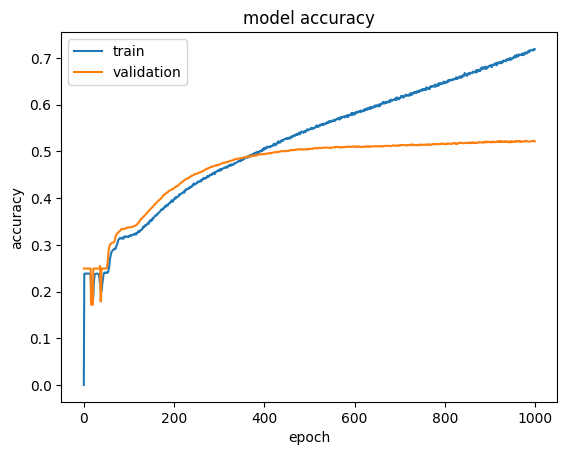

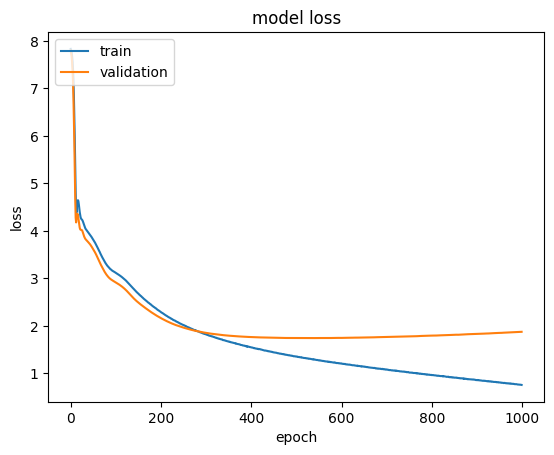

In [13]:
import matplotlib.pyplot as plt

fitted_history = fit_history.history

print(fitted_history.keys())

plt.plot(fitted_history['acc'])
plt.plot(fitted_history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fitted_history['loss'])
plt.plot(fitted_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
TEST_DATA = os.path.join(DATA_DIRECTORY, "combined_test.csv")
TEST_IMAGES = os.path.join(DATA_DIRECTORY, "scene_img_abstract_v002_test2015")

In [17]:
def find_max_value_index(predictions):
    max_index = 0
    max_value = -99999999.99
    for index, value in enumerate(predictions):
        if value > max_value:
            max_index = index
            max_value = value
    return max_index, max_value

def answer_question(image_filepath, question_text):
    embedding_input = get_encoded_image_question(image_filepath, question_text)
    embedding_input = [embedding_input]
    ds = tf.data.Dataset.from_tensor_slices([embedding_input])
    predicted = qa_model.predict(ds)
    predicted_as_list = predicted.tolist()[0]
    return find_max_value_index(predicted_as_list)

def test_qa(image_filepath, question_text):
    print(f'Question: {question_text} (image: {image_filepath})')
    answer_index, answer_prob_value = answer_question(image_filepath, question_text)
    answer = unique_answers[answer_index]
    print(f'The answer found is: {answer} (output_value: {answer_prob_value})')

def get_image_path(filename):
    return os.path.join(TEST_IMAGES, filename)

# testing
cnn_test_df = pd.read_csv(TEST_DATA)
sample_df = cnn_test_df.sample(25)

for index, test_row in sample_df.iterrows():
    test_qa(get_image_path(test_row['image_filename']), test_row['question'])



Question: What color is the string? (image: ./data/scene_img_abstract_v002_test2015/abstract_v002_test2015_000000048120.png)
1/1 [==============================] - 0s 3ms/step
The answer found is: white (output_value: 0.43444642424583435)
Question: What is in the box? (image: ./data/scene_img_abstract_v002_test2015/abstract_v002_test2015_000000040855.png)
1/1 [==============================] - 0s 3ms/step
The answer found is: sand (output_value: 0.9617587327957153)
Question: Did the baby fall over? (image: ./data/scene_img_abstract_v002_test2015/abstract_v002_test2015_000000035620.png)
1/1 [==============================] - 0s 3ms/step
The answer found is: yes (output_value: 0.5482330322265625)
Question: What fruit is the woman eating? (image: ./data/scene_img_abstract_v002_test2015/abstract_v002_test2015_000000049330.png)
1/1 [==============================] - 0s 3ms/step
The answer found is: watermelon (output_value: 0.5226156115531921)
Question: Is the table near the window? (image: